# 3D image classification from CT scans

**Author:** Jonas Brändli<br>
**Date created:** 2022/05/20<br>
**Last modified:** 2022/05/24<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia. Visualize important regions with occlusion.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

Inspired by:
https://github.com/mariannnne/neurolime/blob/master/neurolime_dev_v6_forblanca.ipynb

## Setup

In [1]:
!pip install matplotlib==3.4
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [3]:
from google.colab import drive
from os.path import exists

drive.mount('/content/drive')

reload_data = False # if True reloads data from github and saves it to g drive
refit_model = False # if True fits model and saves it to g drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if reload_data: 
  # Download url of normal CT scans.
  url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
  filename = os.path.join(os.getcwd(), "CT-0.zip")
  keras.utils.get_file(filename, url)

  # Download url of abnormal CT scans.
  url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
  filename = os.path.join(os.getcwd(), "CT-23.zip")
  keras.utils.get_file(filename, url)

  # Make a directory to store the data.
  os.makedirs("MosMedData")

  # Unzip data in the newly created directory.
  with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
      z_fp.extractall("./MosMedData/")

  with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
      z_fp.extractall("./MosMedData/")

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [5]:

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the CT scans from the class directories.

In [6]:
if reload_data:
  # Folder "CT-0" consist of CT scans having normal lung tissue,
  # no CT-signs of viral pneumonia.
  normal_scan_paths = [
      os.path.join(os.getcwd(), "MosMedData/CT-0", x)
      for x in os.listdir("MosMedData/CT-0")
  ]
  # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
  # involvement of lung parenchyma.
  abnormal_scan_paths = [
      os.path.join(os.getcwd(), "MosMedData/CT-23", x)
      for x in os.listdir("MosMedData/CT-23")
  ]

  print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
  print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [7]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
if reload_data:
  abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
  normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

  np.save('/content/drive/MyDrive/Colab Notebooks/xAI_MRI/abnormal_scans.npy', abnormal_scans)
  np.save('/content/drive/MyDrive/Colab Notebooks/xAI_MRI/normal_scans.npy', normal_scans)
elif not reload_data:
  abnormal_scans = np.load('/content/drive/MyDrive/Colab Notebooks/xAI_MRI/abnormal_scans.npy')
  normal_scans = np.load('/content/drive/MyDrive/Colab Notebooks/xAI_MRI/normal_scans.npy')

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

In [8]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [9]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64, 3)


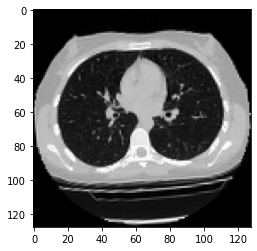

In [27]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]))


In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

Since a CT scan has many slices, let's visualize a montage of the slices.

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [29]:

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

## Train model

In [30]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

if (refit_model):
  # Define callbacks.
  checkpoint_cb = keras.callbacks.ModelCheckpoint(
      "/content/drive/MyDrive/Colab Notebooks/xAI_MRI/3d_image_classification_new.h5", 
      save_best_only=True
  )
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

  # Train the model, doing validation at the end of each epoch
  epochs = 100

  model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=epochs,
      shuffle=True,
      verbose=2,
      callbacks=[checkpoint_cb, early_stopping_cb],
  )

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

In [31]:
if (refit_model):
  fig, ax = plt.subplots(1, 2, figsize=(20, 3))
  ax = ax.ravel()

  for i, metric in enumerate(["acc", "loss"]):
      ax[i].plot(model.history.history[metric])
      ax[i].plot(model.history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])

A validation acc of approx 75% is achieved.

In [32]:
# Load best weights.
if (refit_model):
  model.load_weights("/content/drive/MyDrive/Colab Notebooks/xAI_MRI/3d_image_classification_new.h5")
elif not (refit_model):
  model.load_weights("/content/drive/MyDrive/Colab Notebooks/xAI_MRI/3d_image_classification.h5")

## Make predictions on a single CT scan

In [33]:
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 50.76 percent confident that CT scan is normal
This model is 49.24 percent confident that CT scan is abnormal


## Plot a scan

In [34]:
data = validation_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0] # 
image = image = (np.stack((image[:,:,:,0],)*3, axis=-1))
label = labels.numpy()[0]
print("Dimension of the CT scan is:", image.shape)
print("Label is: ", label)

Dimension of the CT scan is: (128, 128, 64, 3)
Label is:  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


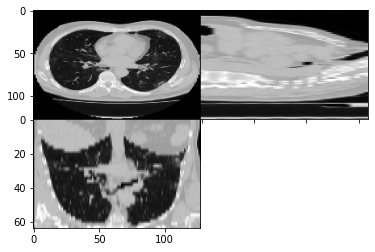

In [35]:
f, axs = plt.subplots(2, 2, 
                      sharex="col", sharey="row",
                      gridspec_kw={'hspace': 0, 'wspace': 0})
(ax1, ax2), (ax3, ax4) = axs
ax1.imshow(np.squeeze(image[:, :, 31]))
ax2.imshow(np.squeeze(image[:, 64, :]))
ax3.imshow(np.flipud(np.rot90(np.squeeze(image[64, :, :]))))
ax4.axis('off')

for ax in axs.flat:
    ax.label_outer()
    ax.set_aspect('auto', anchor = 'NW')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


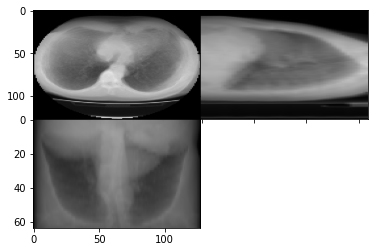

In [36]:
f, axs = plt.subplots(2, 2, 
                      sharex="col", sharey="row",
                      gridspec_kw={'hspace': 0, 'wspace': 0})
(ax1, ax2), (ax3, ax4) = axs
ax1.imshow(np.squeeze(np.mean(image, axis = 2)))
ax2.imshow(np.squeeze(np.mean(image, axis = 1)))
ax3.imshow(np.flipud(np.rot90(np.squeeze(np.mean(image, axis = 0)))))
ax4.axis('off')

for ax in axs.flat:
    ax.label_outer()
    ax.set_aspect('auto', anchor = 'NW')

## Lime

In [38]:
# explainer = lime_image.LimeImageExplainer(random_state=42)

# exp = explainer.explain_instance(
#     image.astype('double'), 
#     model.predict,  
#     num_samples=50, 
#     top_labels=None)

RuntimeError: ignored

In [ ]:
# Give all our voxels names cause Lime wants that
feat_names = range(1,x_train.shape[1]+1)

# Give our class labels names too
label_names = ['novel', 'target']

explainer = lime_image.LimeTabularExplainer(x_train, feature_names=feat_names, class_names=label_names, discretize_continuous=False,feature_selection='none')



In [ ]:
# explain an instance
# set up num features
n_feat=x_train.shape[1] # numb of vox
# set up num samples
n_samp=2000 #not sure what to set this
exp = explainer.explain_instance(x_test[0], clf.predict_proba, num_features=n_feat, num_samples=n_samp, top_labels=None)
# num_features: maximum number of features present in explanation

In [ ]:
# from scipy import stats
# from tqdm import tqdm

# def iter_occlusion(volume, size=4, stride = None):
#   # volume: np array in shape 128, 128, 64, 1

#   occlusion_center = np.full((size, size, size, 1), [0.5], np.float32)

#   for z in range(0, volume.shape[0]-size+1, stride):
#     for y in range(0, volume.shape[1]-size+1, stride):
#       for x in range(0, volume.shape[2]-size+1, stride):
#         tmp = volume.copy()

#         tmp[z:z + size, y:y + size, x:x + size] = occlusion_center

#         yield x, y, z, tmp
  
# def volume_occlusion(volume, correct_class, occlusion_size, occlusion_stride = None):

#   print('occluding...')

#   if occlusion_stride is None:
#     stride = occlusion_size
#   elif occlusion_stride > occlusion_size:
#     raise ValueError('stride must be smaller or equal size')
  
#   if occlusion_stride == occlusion_size:
#     if (not (volume.shape[0] / occlusion_size).is_integer() or
#         not (volume.shape[1] / occlusion_size).is_integer() or 
#         not (volume.shape[2] / occlusion_size).is_integer()):
      
#       raise ValueError('size does not work with this volume')
#   elif occlusion_stride != occlusion_size:
#     if (((volume.shape[0]-occlusion_size) % occlusion_stride) != 0 or 
#         ((volume.shape[1]-occlusion_size) % occlusion_stride) != 0 or
#         ((volume.shape[2]-occlusion_size) % occlusion_stride) != 0):
      
#       raise ValueError('shape and size do not match')

#   num_occlusion =  int(np.prod(((np.array(volume.shape[0:3]) - occlusion_size) / occlusion_stride) + 1))
  
#   # heatmap_n = np.empty((num_occlusion, volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
#   # heatmap_n[:] = np.nan
#   # class_pixels_n = np.empty((num_occlusion, volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
#   # class_pixels_n[:] = np.nan

#   heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
#   heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

#   from collections import defaultdict
#   counters = defaultdict(int)

#   for n, (x, y, z, vol_float) in tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
#       X = vol_float.reshape(1, 128, 128, 64, 1)
#       out = model.predict(X)
#       # print(out)
#       # print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
#       # print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))
#       # plt.imshow(np.squeeze(X), cmap="gray", vmin = 0, vmax = 1)
#       # plt.show()

#       # print(n)

#       # heatmap_n[n, z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] = out[0,0] #[correct_class]
#       # class_pixels_n[n, z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] = 1 if out[0,0] > 0.5 else 0 #np.argmax(out)

#       heatmap_prob_sum[z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] += out[0,0]
#       heatmap_occ_n[z:z + occlusion_size, y:y + occlusion_size, x:x + occlusion_size] += 1

#       counters[np.argmax(out)] += 1

#   print("\n")
#   print("calculating heatmap...")
#   # heatmap = np.mean(np.ma.array(heatmap_n, mask=np.isnan(heatmap_n)), axis = 0)
#   # class_pixels = np.reshape(stats.mode(class_pixels_n, axis = 0, nan_policy = "omit")[0], (volume.shape))

#   heatmap = heatmap_prob_sum/heatmap_occ_n

#   return heatmap#, class_pixels



In [ ]:
# # occlusion
# occ_size = 16
# occ_stride = 4
# print("number of occlusions: ", int(np.prod(((np.array(image.shape[0:3]) - occ_size) / occ_stride) + 1)))
# print((np.asarray(image[:,:,:,0].shape) - occ_size) % occ_stride)

In [ ]:
# correct_class = label
# print("correct class is: ", correct_class)
# modprob = model.predict(image.reshape(1, 128, 128, 64, 1))[0,0]
# print("probability of abnormal scan is: ", modprob)


# (heatmap) =  volume_occlusion(image, correct_class, occlusion_size = occ_size, occlusion_stride = occ_stride)

In [ ]:
def plot_mean_scans(image, heatmap, plt_image = True, plt_heatmap = True, axs = None, f = None, alpha = 0.5):
  if axs is None and f is None:
    f, axs = plt.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0},
                        figsize=(8,8))

  (ax1, ax2), (ax3, ax4) = axs
  if plt_image:
    ax1.imshow(np.squeeze(np.mean(image, axis = 2)), cmap="gray")
    ax2.imshow(np.squeeze(np.mean(image, axis = 1)), cmap="gray")
    ax3.imshow(np.flipud(np.rot90(np.squeeze(np.mean(image, axis = 0)))), cmap="gray")
  
  if plt_heatmap:
    min_heatmap = np.min(heatmap)
    max_heatmap = np.max(heatmap)

    ax1.imshow(np.mean(heatmap, axis = 2), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    ax2.imshow(np.mean(heatmap, axis = 1), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    im = ax3.imshow(np.flipud(np.rot90(np.mean(heatmap, axis = 0))), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    cb = f.colorbar(im, ax=axs.ravel().tolist())
    cb.ax.axhline(y=modprob, linewidth = 3, c='black')

  ax4.axis('off')

  for ax in axs.flat:
      ax.label_outer()
      ax.set_aspect('auto', anchor = 'NW')

def plot_slice_scans(image, heatmap, plt_image = True, plt_heatmap = True, axs = None, f = None, alpha = 0.5, indices = (64,64,32)):
  if axs is None and f is None:
    f, axs = plt.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0},
                        figsize=(8,8))

  (ax1, ax2), (ax3, ax4) = axs
  if plt_image:
    ax1.imshow(np.squeeze(image[:, :, indices[2]]), cmap="gray")
    ax2.imshow(np.squeeze(image[:, indices[1], :]), cmap="gray")
    ax3.imshow(np.flipud(np.rot90(np.squeeze(image[indices[0], :, :]))), cmap="gray")
  
  if plt_heatmap:
    min_heatmap = np.min(heatmap)
    max_heatmap = np.max(heatmap)

    ax1.imshow(np.squeeze(heatmap[:, :, indices[2]]), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    ax2.imshow(np.squeeze(heatmap[:, indices[1], :]), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    im = ax3.imshow(np.flipud(np.rot90(np.squeeze(heatmap[indices[0], :, :]))), cmap='jet_r', vmin = min_heatmap, vmax = max_heatmap, alpha=alpha)
    cb = f.colorbar(im, ax=axs.ravel().tolist())
    cb.ax.axhline(y=modprob, linewidth = 3, c='black')

  ax4.axis('off')

  for ax in axs.flat:
      ax.label_outer()
      ax.set_aspect('auto', anchor = 'NW')


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(30, 10))

(subfig1, subfig2, subfig3) = fig.subfigures(1, 3)

# for outerind, subfig in enumerate(subfigs.flat):
#     subfig.suptitle(f'Subfig {outerind}')
#     axs = subfig.subplots(2, 2, 
#                         sharex="col", sharey="row",
#                         gridspec_kw={'hspace': 0, 'wspace': 0})
#     plot_scans(image, heatmap, plt_heatmap = False, axs = axs, f = fig)

axs = subfig1.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_mean_scans(image, heatmap, plt_heatmap = False, axs = axs, f = fig)

axs = subfig2.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_mean_scans(image, heatmap, axs = axs, f = fig)

axs = subfig3.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_mean_scans(image, heatmap, plt_image = False, axs = axs, f = fig, alpha = 1)


In [ ]:
minprob = np.unravel_index(heatmap.argmin(), heatmap.shape)
print(minprob)
fig = plt.figure(constrained_layout=True, figsize=(30, 10))

(subfig1, subfig2, subfig3) = fig.subfigures(1, 3)

# for outerind, subfig in enumerate(subfigs.flat):
#     subfig.suptitle(f'Subfig {outerind}')
#     axs = subfig.subplots(2, 2, 
#                         sharex="col", sharey="row",
#                         gridspec_kw={'hspace': 0, 'wspace': 0})
#     plot_scans(image, heatmap, plt_heatmap = False, axs = axs, f = fig)

axs = subfig1.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_slice_scans(image, heatmap, plt_heatmap = False, axs = axs, f = fig, indices = minprob)

axs = subfig2.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_slice_scans(image, heatmap, axs = axs, f = fig, indices = minprob)

axs = subfig3.subplots(2, 2, 
                        sharex="col", sharey="row",
                        gridspec_kw={'hspace': 0, 'wspace': 0})
plot_slice_scans(image, heatmap, plt_image = False, axs = axs, f = fig, alpha = 1, indices = minprob)